In [ ]:
import platform, sys, os

In [ ]:
# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

env: PATH=c:\Users\remne\AppData\Local\Microsoft\WindowsApps;c:\Users\remne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files (x86)\Microsoft SQL Server\160\Tools\Binn\;C:\Program Files\Microsoft SQL Server\160\Tools\Binn\;C:\Program Files\Microsoft SQL Server\Client SDK\ODBC\170\Tools\Binn\;C:\Program Files\Microsoft SQL Server\160\DTS\Binn\;C:\Program Files (x86)\Microsoft SQL Server\160\DTS\Binn\;C:\Program Files\Azure Data Studio\bin;C:\Program Files\snap\snaphu\bin;C:\Program Files\MATLAB\R2023b\runtime\win64;C:\Program Files\MATLAB\R2023b\bin;C:\Users\remne\AppData\Roaming\nvm;C:\Program Files\nodejs;C:\Users\remne\A

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!{sys.executable} -m pip install -q git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar

In [ ]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension('vtk')
from contextlib import contextmanager

import matplotlib.pyplot as plt
from contextlib import contextmanager

@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

# Update the settings for a light theme
light_theme_settings = {
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': 'lightgray',
    'text.color': 'black',
    'axes.prop_cycle': plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'white'
}

# Apply the light theme settings
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update(light_theme_settings)

%matplotlib inline








# import matplotlib.pyplot as plt
# contextmanager
# def mpl_settings(settings):
#     original_settings = {k: plt.rcParams[k] for k in settings}
#     plt.rcParams.update(settings)
#     yield
#     plt.rcParams.update(original_settings)
# plt.rcParams['figure.figsize'] = [12, 4]
# plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.titlesize'] = 24
# plt.rcParams['axes.titlesize'] = 14
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12
# %matplotlib inline

In [ ]:
# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [ ]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles

In [ ]:
SCENES = """
S1A_IW_SLC__1SDV_20240421T004848_20240421T004915_053525_067F0A_A009
S1A_IW_SLC__1SDV_20240409T004848_20240409T004915_053350_067822_B3C1
S1A_IW_SLC__1SDV_20240328T004847_20240328T004914_053175_067152_C9AA
S1A_IW_SLC__1SDV_20240316T004847_20240316T004914_053000_066A9D_7836
S1A_IW_SLC__1SDV_20240304T004847_20240304T004914_052825_066491_C450
S1A_IW_SLC__1SDV_20240221T004847_20240221T004914_052650_065EA1_F5CD
S1A_IW_SLC__1SDV_20240209T004847_20240209T004914_052475_0658AE_9906
S1A_IW_SLC__1SDV_20240128T004847_20240128T004914_052300_0652C5_08A5
S1A_IW_SLC__1SDV_20240116T004847_20240116T004914_052125_064CE3_0CA5
S1A_IW_SLC__1SDV_20240104T004848_20240104T004915_051950_0646E9_491C
S1A_IW_SLC__1SDV_20231223T004849_20231223T004916_051775_0640EA_3264
S1A_IW_SLC__1SDV_20231211T004850_20231211T004917_051600_063AD7_A98B
S1A_IW_SLC__1SDV_20231129T004850_20231129T004917_051425_0634C5_65C0
S1A_IW_SLC__1SDV_20231117T004851_20231117T004917_051250_062EBA_EFAE
S1A_IW_SLC__1SDV_20231105T004851_20231105T004918_051075_0628AB_8A54
S1A_IW_SLC__1SDV_20231024T004851_20231024T004918_050900_0622AE_289A
S1A_IW_SLC__1SDV_20231012T004850_20231012T004917_050725_061CBD_AB0E
S1A_IW_SLC__1SDV_20230930T004851_20230930T004918_050550_0616B6_8CC6
S1A_IW_SLC__1SDV_20230918T004851_20230918T004918_050375_0610BA_BCA1
S1A_IW_SLC__1SDV_20230906T004850_20230906T004917_050200_060ACB_D4DD
S1A_IW_SLC__1SDV_20230825T004850_20230825T004917_050025_0604C7_0C53
S1A_IW_SLC__1SDV_20230813T004849_20230813T004916_049850_05FED5_9DA6
S1A_IW_SLC__1SDV_20230801T004848_20230801T004915_049675_05F92D_359D
S1A_IW_SLC__1SDV_20230720T004844_20230720T004916_049500_05F3C5_F156
S1A_IW_SLC__1SDV_20230708T004847_20230708T004914_049325_05EE6E_CDB3
S1A_IW_SLC__1SDV_20230626T004846_20230626T004913_049150_05E906_F71B
S1A_IW_SLC__1SDV_20230614T004845_20230614T004912_048975_05E3BC_2DAF
S1A_IW_SLC__1SDV_20230602T004845_20230602T004912_048800_05DE62_1ABF
S1A_IW_SLC__1SDV_20230521T004844_20230521T004911_048625_05D92B_BBE6
S1A_IW_SLC__1SDV_20230509T004844_20230509T004911_048450_05D402_1A7E
S1A_IW_SLC__1SDV_20230427T004843_20230427T004910_048275_05CE23_ED5F
S1A_IW_SLC__1SDV_20230415T004843_20230415T004910_048100_05C844_2F06
S1A_IW_SLC__1SDV_20230403T004842_20230403T004909_047925_05C255_801F
S1A_IW_SLC__1SDV_20230322T004842_20230322T004909_047750_05BC7E_E426
S1A_IW_SLC__1SDV_20230310T004842_20230310T004909_047575_05B68E_E04C
S1A_IW_SLC__1SDV_20230226T004842_20230226T004909_047400_05B0A6_6949
S1A_IW_SLC__1SDV_20230214T004842_20230214T004909_047225_05AAAA_B9C7
S1A_IW_SLC__1SDV_20230202T004842_20230202T004909_047050_05A4CF_6AC3
S1A_IW_SLC__1SDV_20230121T004842_20230121T004909_046875_059EF3_B488
S1A_IW_SLC__1SDV_20230109T004843_20230109T004910_046700_05990A_6B71
S1A_IW_SLC__1SDV_20221228T004844_20221228T004911_046525_05932B_C9F7
S1A_IW_SLC__1SDV_20221216T004844_20221216T004911_046350_058D32_579C
S1A_IW_SLC__1SDV_20221204T004845_20221204T004912_046175_05873C_F90B
S1A_IW_SLC__1SDV_20221122T004846_20221122T004913_046000_058147_FCF5
S1A_IW_SLC__1SDV_20221110T004845_20221110T004912_045825_057B63_CFAE
S1A_IW_SLC__1SDV_20221029T004846_20221029T004913_045650_057573_553D
S1A_IW_SLC__1SDV_20221005T004846_20221005T004913_045300_056A69_8BC2
S1A_IW_SLC__1SDV_20220923T004845_20220923T004912_045125_056481_F3D4
S1A_IW_SLC__1SDV_20220911T004846_20220911T004913_044950_055E9E_F4FA
S1A_IW_SLC__1SDV_20220830T004845_20220830T004912_044775_0558C3_6300
S1A_IW_SLC__1SDV_20220806T004844_20220806T004911_044425_054D2C_E8C1
S1A_IW_SLC__1SDV_20220725T004843_20220725T004910_044250_05480B_8EDB
S1A_IW_SLC__1SDV_20220713T004842_20220713T004909_044075_0542D5_60CE
S1A_IW_SLC__1SDV_20220701T004842_20220701T004908_043900_053D9E_CC01
S1A_IW_SLC__1SDV_20220619T004841_20220619T004908_043725_053861_F1AC
S1A_IW_SLC__1SDV_20220607T004840_20220607T004907_043550_05332F_D82E
S1A_IW_SLC__1SDV_20220526T004839_20220526T004906_043375_052DFE_E545
S1A_IW_SLC__1SDV_20220514T004838_20220514T004905_043200_0528CA_D5E8
S1A_IW_SLC__1SDV_20220502T004837_20220502T004904_043025_052320_303C
S1A_IW_SLC__1SDV_20220420T004837_20220420T004904_042850_051D58_A2BC
S1A_IW_SLC__1SDV_20220408T004836_20220408T004903_042675_051776_0479
S1A_IW_SLC__1SDV_20220327T004836_20220327T004903_042500_051193_277B
S1A_IW_SLC__1SDV_20220315T004836_20220315T004903_042325_050B9F_6CA0
S1A_IW_SLC__1SDV_20220303T004836_20220303T004903_042150_0505B4_ED86
S1A_IW_SLC__1SDV_20220219T004836_20220219T004903_041975_04FFB2_04C7
S1A_IW_SLC__1SDV_20220207T004836_20220207T004903_041800_04F99F_C315
S1A_IW_SLC__1SDV_20220126T004837_20220126T004904_041625_04F39C_CB3A
S1A_IW_SLC__1SDV_20220114T004837_20220114T004904_041450_04EDA1_EEE9
S1A_IW_SLC__1SDV_20220102T004838_20220102T004905_041275_04E7DD_21EC
S1A_IW_SLC__1SDV_20211221T004838_20211221T004905_041100_04E1FF_7796
S1A_IW_SLC__1SDV_20211209T004839_20211209T004906_040925_04DC27_0A12
S1A_IW_SLC__1SDV_20211127T004839_20211127T004906_040750_04D60E_9C8D
S1A_IW_SLC__1SDV_20211115T004840_20211115T004907_040575_04D00D_0CBA
S1A_IW_SLC__1SDV_20211103T004840_20211103T004907_040400_04C9F0_4C08
S1A_IW_SLC__1SDV_20211022T004840_20211022T004907_040225_04C3D9_765F
S1A_IW_SLC__1SDV_20211010T004840_20211010T004907_040050_04BDBF_F498
S1A_IW_SLC__1SDV_20210928T004840_20210928T004907_039875_04B7B7_EC4F
S1A_IW_SLC__1SDV_20210916T004839_20210916T004906_039700_04B1B8_AF6C
S1A_IW_SLC__1SDV_20210904T004839_20210904T004906_039525_04ABBF_0341
S1A_IW_SLC__1SDV_20210823T004838_20210823T004905_039350_04A5B8_7F06
S1A_IW_SLC__1SDV_20210730T004837_20210730T004904_039000_0499FE_DFFC
S1A_IW_SLC__1SDV_20210718T004836_20210718T004903_038825_0494CB_4D8D
S1A_IW_SLC__1SDV_20210706T004836_20210706T004903_038650_048F8D_4242
S1A_IW_SLC__1SDV_20210624T004835_20210624T004902_038475_048A45_9F82
S1A_IW_SLC__1SDV_20210612T004834_20210612T004901_038300_04850E_91FF
S1A_IW_SLC__1SDV_20210531T004834_20210531T004900_038125_047FDE_FCE2
S1A_IW_SLC__1SDV_20210519T004833_20210519T004900_037950_047A9D_E8F1
S1A_IW_SLC__1SDV_20210507T004832_20210507T004859_037775_047555_75C5
S1A_IW_SLC__1SDV_20210425T004832_20210425T004859_037600_046F51_41DC
S1A_IW_SLC__1SDV_20210413T004831_20210413T004858_037425_046947_A97D
S1A_IW_SLC__1SDV_20210401T004831_20210401T004858_037250_04633D_EE19
S1A_IW_SLC__1SDV_20210320T004830_20210320T004857_037075_045D33_C4C3
S1A_IW_SLC__1SDV_20210308T004830_20210308T004857_036900_045718_FB8A
S1A_IW_SLC__1SDV_20210224T004830_20210224T004857_036725_0450FC_D128
S1A_IW_SLC__1SDV_20210212T004831_20210212T004858_036550_044AE4_13B8
S1A_IW_SLC__1SDV_20210131T004831_20210131T004858_036375_0444D2_D89D
S1A_IW_SLC__1SDV_20210119T004831_20210119T004858_036200_043EBF_7BD0
S1A_IW_SLC__1SDV_20210107T004832_20210107T004859_036025_043899_294E
S1A_IW_SLC__1SDV_20201214T004833_20201214T004900_035675_042C79_5D66
S1A_IW_SLC__1SDV_20201202T004833_20201202T004900_035500_042679_99E0
S1A_IW_SLC__1SDV_20201120T004834_20201120T004901_035325_042066_F182
S1A_IW_SLC__1SDV_20201108T004834_20201108T004901_035150_041A4C_59CC
S1A_IW_SLC__1SDV_20201027T004834_20201027T004901_034975_041443_E6D8
S1A_IW_SLC__1SDV_20201015T004834_20201015T004901_034800_040E3E_59DE
S1A_IW_SLC__1SDV_20201003T004834_20201003T004901_034625_040826_ED7D
S1A_IW_SLC__1SDV_20200921T004834_20200921T004901_034450_040203_D4A8
S1A_IW_SLC__1SDV_20200909T004833_20200909T004900_034275_03FBC3_C92E
S1A_IW_SLC__1SDV_20200828T004833_20200828T004900_034100_03F59C_B653
S1A_IW_SLC__1SDV_20200816T004832_20200816T004859_033925_03EF73_E2E6
S1A_IW_SLC__1SDV_20200804T004832_20200804T004859_033750_03E969_E401
S1A_IW_SLC__1SDV_20200723T004831_20200723T004858_033575_03E415_88E2
S1A_IW_SLC__1SDV_20200711T004830_20200711T004857_033400_03DEB2_509E
S1A_IW_SLC__1SDV_20200629T004829_20200629T004856_033225_03D963_ECB1
S1A_IW_SLC__1SDV_20200617T004829_20200617T004856_033050_03D413_5842
S1A_IW_SLC__1SDV_20200605T004828_20200605T004855_032875_03CED0_754D
S1A_IW_SLC__1SDV_20200524T004827_20200524T004854_032700_03C99E_E00D
S1A_IW_SLC__1SDV_20200512T004827_20200512T004853_032525_03C451_B4F8
S1A_IW_SLC__1SDV_20200430T004826_20200430T004853_032350_03BE8B_3BE0
S1A_IW_SLC__1SDV_20200418T004825_20200418T004852_032175_03B867_F1A4
S1A_IW_SLC__1SDV_20200406T004825_20200406T004852_032000_03B23A_0951
S1A_IW_SLC__1SDV_20200325T004825_20200325T004852_031825_03AC19_0EB6
S1A_IW_SLC__1SDV_20200313T004825_20200313T004851_031650_03A5E6_DB33
S1A_IW_SLC__1SDV_20200301T004824_20200301T004851_031475_039FD3_57E2
S1A_IW_SLC__1SDV_20200218T004825_20200218T004851_031300_0399D4_AA53
S1A_IW_SLC__1SDV_20200125T004825_20200125T004852_030950_038DA9_947E
S1A_IW_SLC__1SDV_20200113T004825_20200113T004852_030775_03877F_1609
S1A_IW_SLC__1SDV_20200101T004826_20200101T004853_030600_03816B_2704
S1A_IW_SLC__1SDV_20191220T004827_20191220T004853_030425_037B60_6983
S1A_IW_SLC__1SDV_20191208T004827_20191208T004854_030250_037551_DA00
S1A_IW_SLC__1SDV_20191126T004827_20191126T004854_030075_036F51_D2B6
S1A_IW_SLC__1SDV_20191114T004828_20191114T004855_029900_036940_090D
S1A_IW_SLC__1SDV_20191102T004828_20191102T004855_029725_03631A_48BE
S1A_IW_SLC__1SDV_20191021T004828_20191021T004855_029550_035D07_57D8
S1A_IW_SLC__1SDV_20191009T004828_20191009T004855_029375_0356FE_CF44
S1A_IW_SLC__1SDV_20190927T004828_20190927T004855_029200_0350EE_DF9A
S1A_IW_SLC__1SDV_20190915T004827_20190915T004854_029025_034AFD_E759
S1A_IW_SLC__1SDV_20190903T004827_20190903T004854_028850_0344E8_CCAE
S1A_IW_SLC__1SDV_20190822T004826_20190822T004853_028675_033ED2_0E8A
S1A_IW_SLC__1SDV_20190810T004826_20190810T004852_028500_0338BB_11CA
S1A_IW_SLC__1SDV_20190729T004825_20190729T004852_028325_03334B_4F79
S1A_IW_SLC__1SDV_20190717T004824_20190717T004851_028150_032DF4_5B17
S1A_IW_SLC__1SDV_20190705T004823_20190705T004850_027975_0328A5_6D67
S1A_IW_SLC__1SDV_20190623T004822_20190623T004849_027800_03235E_B5B7
S1A_IW_SLC__1SDV_20190611T004821_20190611T004848_027625_031E21_3650
S1A_IW_SLC__1SDV_20190530T004821_20190530T004848_027450_0318C7_6BD5
S1A_IW_SLC__1SDV_20190518T004820_20190518T004847_027275_031350_2ACD
S1A_IW_SLC__1SDV_20190506T004820_20190506T004847_027100_030DD1_C80E
S1A_IW_SLC__1SDV_20190424T004819_20190424T004846_026925_03076D_A658
S1A_IW_SLC__1SDV_20190412T004819_20190412T004846_026750_030118_FE00
S1A_IW_SLC__1SDV_20190331T004819_20190331T004846_026575_02FAB1_A40E
S1A_IW_SLC__1SDV_20190319T004818_20190319T004845_026400_02F442_8D82
S1A_IW_SLC__1SDV_20190307T004818_20190307T004845_026225_02EDC8_BD19
S1A_IW_SLC__1SDV_20190223T004818_20190223T004845_026050_02E789_58A5
S1A_IW_SLC__1SDV_20190211T004818_20190211T004845_025875_02E153_DA11
S1A_IW_SLC__1SDV_20190118T004819_20190118T004846_025525_02D49F_B940
S1A_IW_SLC__1SDV_20190106T004819_20190106T004846_025350_02CE4F_4D57
"""
SCENES = list(filter(None, SCENES.split('\n')))
print (f'Scenes defined: {len(SCENES)}')

# Defining the middle scene to compare and contrast the interferograms.
ORBIT     = 'A'
SUBSWATH  = 3
REFERENCE = '2022-01-02'

Scenes defined: 158


In [ ]:
WORKDIR = "C:\\Users\\remne\\Documents\\raw_sub"
DATADIR = "C:\\Users\\remne\\Documents\\data_sub"
# define DEM filename outside data directory
DEM = 'dem.nc'

In [ ]:
import geopandas as gpd
import json

# Define the GeoJSON string for the Polygon
geojson_polygon = '''
{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [-99.009015, 19.294078],
        [-99.256117, 19.294078],
        [-99.256117, 19.520101],
        [-99.009015, 19.520101],
        [-99.009015, 19.294078]
      ]
    ]
  }
}
'''

# Convert the GeoJSON string to a GeoDataFrame
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson_polygon)])

# Print the GeoDataFrame to verify
print(AOI)


                                                                                              geometry
0  POLYGON ((-99.00902 19.29408, -99.25612 19.29408, -99.25612 19.52010, -99.00902 19.52010, -99.00...


In [ ]:
# define the buffer to cover only one burst
BUFFER = 0.035
AOI['geometry'] = AOI.buffer(BUFFER)

In [ ]:
import geopandas as gpd
import json

# Define the GeoJSON string for the point in Mexico City
geojson_mexico_city = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-99.13356332073042, 19.43393365718681]
  },
  "properties": {}
}
'''

# Convert the GeoJSON string to a GeoDataFrame
POI= gpd.GeoDataFrame.from_features([json.loads(geojson_mexico_city)])

# Print the GeoDataFrame to verify
print(POI)

                     geometry
0  POINT (-99.13356 19.43393)


In [ ]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'GoogleColab2023'
asf_password = 'GoogleColab_2023'

In [ ]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)
# Optimized scene downloading from ASF - only the required subswaths and polarizations.
print(asf.download_scenes(DATADIR, SCENES, SUBSWATH))

None


In [ ]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

In [ ]:
# download the digital elevation model (DEM)
Tiles().download_dem_srtm(AOI, filename=DEM).plot.imshow()
AOI.boundary.plot(ax=plt.gca(), color='red')

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\remne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\remne\AppData\Local\Temp\ipykernel_33724\742867539.py", line 2, in <module>
    Tiles().download_dem_srtm(AOI, filename=DEM).plot.imshow()
  File "C:\Users\remne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xarray\plot\accessor.py", line 421, in imshow
    return dataarray_plot.imshow(self._da, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\remne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xarray\plot\dataarray_plot.py", line 1563, in newplotfunc
    zval = darray.to_masked_arra

In [ ]:
# simple Dask initialization to handle parallel computing tasks
if 'client' in globals():
    client.close()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 63.64 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56175,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 63.64 GiB
Comm: tcp://127.0.0.1:56210,Total threads: 4
Dashboard: http://127.0.0.1:56211/status,Memory: 12.73 GiB
Nanny: tcp://127.0.0.1:56178,


In [ ]:
# Sets up the SAR Scenes for initial preprocessing
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)
# Initialize with the Stack Class to handle the stack of SAR Scenes
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes).set_reference(REFERENCE)
sbas.to_dataframe()

NOTE: auto set reference scene 2019-01-06. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2019-01-06,2019-01-06 00:48:20,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190106T004819_20190106T004846_025350_02CE4F...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190106T004819_20190106T004846_025350_02CE4F...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210310T171508_V20190105T225942_2019...,"MULTIPOLYGON (((-99.38079 18.27929, -99.34185 18.28632, -99.30309 18.29331, -99.26449 18.30026, ..."
2019-01-18,2019-01-18 00:48:20,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190118T004819_20190118T004846_025525_02D49F...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190118T004819_20190118T004846_025525_02D49F...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210310T210353_V20190117T225942_2019...,"MULTIPOLYGON (((-99.38127 18.27904, -99.34234 18.28607, -99.30358 18.29306, -99.26498 18.30001, ..."
2019-02-11,2019-02-11 00:48:19,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190211T004818_20190211T004845_025875_02E153...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190211T004818_20190211T004845_025875_02E153...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T045041_V20190210T225942_2019...,"MULTIPOLYGON (((-99.38137 18.27899, -99.34243 18.28602, -99.30367 18.29301, -99.26508 18.29997, ..."
2019-02-23,2019-02-23 00:48:19,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190223T004818_20190223T004845_026050_02E789...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190223T004818_20190223T004845_026050_02E789...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T084417_V20190222T225942_2019...,"MULTIPOLYGON (((-99.38184 18.27870, -99.34291 18.28573, -99.30414 18.29272, -99.26555 18.29967, ..."
2019-03-07,2019-03-07 00:48:19,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190307T004818_20190307T004845_026225_02EDC8...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190307T004818_20190307T004845_026225_02EDC8...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T123215_V20190306T225942_2019...,"MULTIPOLYGON (((-99.38216 18.27834, -99.34322 18.28537, -99.30446 18.29236, -99.26586 18.29931, ..."
2019-03-19,2019-03-19 00:48:19,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190319T004818_20190319T004845_026400_02F442...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190319T004818_20190319T004845_026400_02F442...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T160254_V20190318T225942_2019...,"MULTIPOLYGON (((-99.38137 18.27858, -99.34243 18.28561, -99.30367 18.29260, -99.26507 18.29955, ..."
2019-03-31,2019-03-31 00:48:20,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190331T004819_20190331T004846_026575_02FAB1...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190331T004819_20190331T004846_026575_02FAB1...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T194727_V20190330T225942_2019...,"MULTIPOLYGON (((-99.38214 18.27833, -99.34320 18.28536, -99.30444 18.29235, -99.26585 18.29930, ..."
2019-04-12,2019-04-12 00:48:20,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190412T004819_20190412T004846_026750_030118...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190412T004819_20190412T004846_026750_030118...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210311T233402_V20190411T225942_2019...,"MULTIPOLYGON (((-99.38091 18.27886, -99.34197 18.28589, -99.30321 18.29288, -99.26462 18.29983, ..."
2019-04-24,2019-04-24 00:48:20,A,S1A,VV,3,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190424T004819_20190424T004846_026925_03076D...,C:\Users\remne\Documents\data_sub\S1A_IW_SLC__1SDV_20190424T004819_20190424T004846_026925_03076D...,C:\Users\remne\Documents\data_sub\S1A_OPER_AUX_POEORB_OPOD_20210312T031015_V20190423T225942_2019...,"MULTIPOL

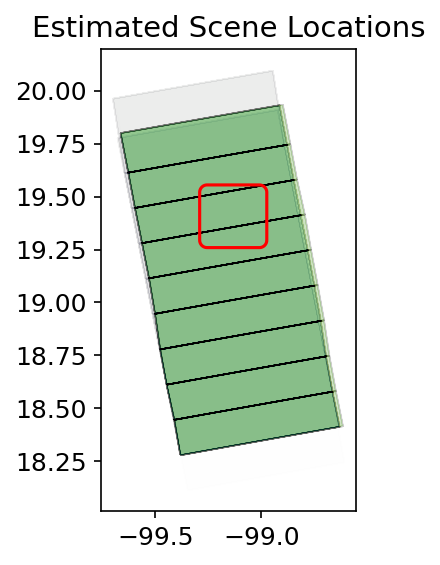

In [ ]:
# Plot a scene with the area of interest previously defined.
map_tiles = XYZTiles().download_googlesatellitehybrid(sbas.to_dataframe(), zoom=8)
sbas.plot_scenes(AOI=AOI, image=map_tiles, aspect='equal')

In [ ]:
# Reframing the scene to only include the specific swath that are spans within the area of interest. This is done to lower computational power and only focus on processing the swaths that are in use
sbas.compute_reframe(AOI)

                                                                                              geometry
0  POLYGON ((-98.97402 19.29408, -98.97418 19.29065, -98.97469 19.28725, -98.97552 19.28392, -98.97...


Reframing:   0%|          | 0/156 [00:00<?, ?it/s]

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
map_tiles = XYZTiles().download_googlesatellitehybrid(sbas.to_dataframe(), zoom=9)
sbas.plot_scenes(AOI=AOI, image=map_tiles, aspect='equal')

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)

Aligning Reference:   0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
map_tiles = XYZTiles().download_googlesatellitehybrid(sbas.to_dataframe(), zoom=9)
sbas.plot_scenes(AOI=AOI, image=map_tiles, alpha=0.3, aspect='equal')

2024-04-29 21:48:52,039 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:59922', name: 2, status: running, memory: 0, processing: 0>
2024-04-29 21:48:52,041 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:59924', name: 3, status: running, memory: 0, processing: 0>
2024-04-29 21:48:52,045 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:59926', name: 4, status: running, memory: 0, processing: 0>
2024-04-29 21:48:52,057 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:59922'.
2024-04-29 21:48:52,060 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:59926'.
2024-04-29 21:48:52,063 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:599

KeyboardInterrupt: 

2024-04-30 13:07:06,523 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:59923', name: 0, status: running, memory: 0, processing: 0>
2024-04-30 13:07:06,528 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:59923'.
2024-04-30 13:07:10,981 - distributed.nanny - WARNING - Restarting worker
2024-04-30 15:31:52,003 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:59925', name: 1, status: running, memory: 0, processing: 0>
2024-04-30 15:31:52,014 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:59925'.


In [ ]:
# Geometrically aligns, Coregisters and preserve precision and accuracy of the SAR scenes on the area of interest.
sbas.compute_align()

In [ ]:
sbas.backup('backup')
!rm -fr backup

Geocode

In [ ]:
sbas.compute_geocode(1)

In [ ]:
topo = sbas.get_topo()
topo

In [ ]:
sbas.plot_topo(quantile=[0.01, 0.99])

In [ ]:
baseline_pairs = sbas.sbas_pairs(days=50, meters=150)
# optionally, drop not well connected pairs
baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
baseline_pairs

In [ ]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)

In [ ]:
# use the only selected dates for the pixels stability analysis
# Identifies and analyse the Persistent Scatterers within the Small Baseline Subset (SBAS) framework
sbas.compute_ps()

In [ ]:
# Define the Persistent Scattering Functions and apply it onto the Persistent Scattering Data
psfunction = sbas.psfunction()
psfunction

In [ ]:
sbas.plot_psfunction(quantile=[0.01, 0.90])

In [ ]:
# export PSF raster as GeoTiFF file to view in QGIS, ArcGIS, etc.
sbas.export_geotiff(psfunction, 'psfunction')

In [ ]:
# Computes Interferograms using baseline pairs to ensure temporal accuracies, preserve pixel accuracy, with the weights calculated by the persistent scattering function.
sbas.compute_interferogram_multilook(baseline_pairs, 'intf_mlook', wavelength=30, weight=sbas.psfunction())

In [ ]:
sbas.plot_interferograms(intf_sbas[:8], caption='SBAS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_sbas[:8], caption='SBAS Correlation')

In [ ]:
baseline_pairs['corr'] = corr_sbas.mean(['y', 'x'])
baseline_pairs

In [ ]:
baseline_pairs_best = sbas.sbas_pairs_covering_correlation(baseline_pairs, 3)
# optionally, drop not well connected pairs
baseline_pairs_best = sbas.sbas_pairs_limit(baseline_pairs_best, limit=2, iterations=2)
print (len(baseline_pairs_best))
baseline_pairs_best

In [ ]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs_best)

In [ ]:
sbas.plot_baseline_correlation(baseline_pairs, baseline_pairs_best)

In [ ]:
sbas.plot_baseline_duration(baseline_pairs, column='corr', ascending=True)

In [ ]:
sbas.plot_baseline_duration(baseline_pairs_best, column='corr', ascending=True)

In [ ]:
intf_sbas = intf_sbas.sel(pair=baseline_pairs_best.pair.values)
corr_sbas = corr_sbas.sel(pair=baseline_pairs_best.pair.values)
baseline_pairs = baseline_pairs_best

In [ ]:
# Unwrap the interferograms using the correlation mapping to ensure areas with high correlation are accurately unwrap those regions to reduce phase noise and other errors for those areas.
unwrap_sbas = sbas.unwrap_snaphu(intf_sbas, corr_sbas)
unwrap_sbas

In [ ]:
# Synchronize the SBAS data processing.
unwrap_sbas = sbas.sync_cube(unwrap_sbas, 'unwrap_sbas')

In [ ]:
sbas.plot_phases(unwrap_sbas.phase[:8], caption='SBAS Phase, [rad]')

In [ ]:
# use limited set of fitting variables because otherwise overfitting is very likely for small areas
# down-samples the data to reduce computational load
decimator = sbas.decimator(resolution=15, grid=(1,1))
topo = decimator(sbas.get_topo())
inc = decimator(sbas.incidence_angle())
yy, xx = xr.broadcast(topo.y, topo.x)


# Perform regression to isolate deformation signals, seasonal effects (aquifers recharge/discharge)
trend_sbas = sbas.regression(unwrap_sbas.phase, [topo, topo*yy, topo*xx, topo*yy*xx, yy, xx, inc], corr_sbas)

In [ ]:
trend_sbas = sbas.sync_cube(trend_sbas, 'trend_sbas')

In [ ]:
sbas.plot_phases(trend_sbas[:8], caption='SBAS Trend Phase, [rad]', quantile=[0.01, 0.99])

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas)[:8], caption='SBAS Phase - Trend, [rad]', vmin=-np.pi, vmax=np.pi)

In [ ]:
# Removes turbulent atmospheric phase delays, subtracts turbulent atmospheric delays from unwrapped phase data to refine phase measurements.
turbo_sbas = sbas.polyfit(unwrap_sbas.phase - trend_sbas, corr_sbas)
turbo_sbas

In [ ]:
turbo_sbas = sbas.sync_cube(turbo_sbas, 'turbo_sbas')

In [ ]:
sbas.plot_phases(turbo_sbas[:8], caption='SBAS Phase Turbo, [rad]', vmin=-np.pi, vmax=np.pi)

In [ ]:
# optionally, materialize to disk and open
turbo_sbas = sbas.sync_cube(turbo_sbas, 'turbo_sbas')

In [ ]:
sbas.plot_phases(turbo_sbas[:8], caption='SBAS Phase Turbo, [rad]', vmin=-np.pi, vmax=np.pi)

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas - turbo_sbas)[:8],
                 caption='SBAS Phase - Trend - Turbo, [rad]', vmin=-np.pi, vmax=np.pi)

In [ ]:
# Apply the polynomial fitting to the adjusted phase data to remove any systematic phase variations
turbo2_sbas = sbas.polyfit(unwrap_sbas.phase - trend_sbas - turbo_sbas, corr_sbas)

In [ ]:
turbo2_sbas = sbas.sync_cube(turbo2_sbas, 'turbo2_sbas')

In [ ]:
sbas.plot_phases(turbo2_sbas[:8], caption='SBAS Phase Turbo 2, [rad]', vmin=-np.pi/4, vmax=np.pi/4)

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas - turbo_sbas - turbo2_sbas)[:12],
                 caption='SBAS Phase - Trend - Turbo - Turbo2, [rad]', vmin=-np.pi, vmax=np.pi)

In [ ]:
# calculate phase displacement in radians and convert to LOS displacement in millimeter
disp_sbas = sbas.lstsq(unwrap_sbas.phase - trend_sbas - turbo_sbas - turbo2_sbas, corr_sbas)

In [ ]:
disp_sbas = sbas.sync_cube(disp_sbas, 'disp_sbas')

In [ ]:
sbas.plot_displacements_los_mm(disp_sbas[::10], caption='SBAS Cumulative LOS Displacement, [mm]',
                        quantile=[0.01, 0.99], symmetrical=True)

In [ ]:
# define corrected phase pairs
disp_sbas_pairs = sbas.wrap(intf_sbas - trend_sbas - turbo_sbas - turbo2_sbas).rename('phase')

In [ ]:
rmse_sbas = sbas.rmse(disp_sbas_pairs, disp_sbas, corr_sbas)
rmse_sbas

In [ ]:
# optionally, materialize to disk and open
rmse_sbas = sbas.sync_cube(rmse_sbas, 'rmse_sbas')

In [ ]:
sbas.plot_rmse_los_mm(rmse_sbas,
                      caption='SBAS RMSE, [mm]',
                      quantile=[0.01,0.99],
                      POI=sbas.geocode(POI))

In [ ]:
x, y = [(geom.x.item(), geom.y.item()) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_sbas_pairs.sel(y=y, x=x, method='nearest'),
                                       corr_sbas.sel(y=y, x=x, method='nearest'),
                                       caption='SBAS POI LSQ and STL Displacement Models, [mm]', stl=True, linewidth=2)

In [ ]:
velocity_sbas = sbas.velocity(disp_sbas)
velocity_sbas

In [ ]:
# export PSF raster as GeoTiFF file to view in QGIS, ArcGIS, etc.
sbas.export_geotiff(velocity_sbas, 'velocity_sbas')

In [ ]:
# optionally, materialize to disk and open
velocity_sbas = sbas.sync_cube(velocity_sbas, 'velocity_sbas')

In [ ]:
sbas.plot_velocity_los_mm(velocity_sbas,
                   caption='SBAS LOS Velocity, [mm/year]',
                   POI=sbas.geocode(POI),
                   quantile=[0.01, 0.99], symmetrical=True)
plt.legend(labels=['POI'], loc='upper left', fontsize=14)

In [ ]:
sbas.export_geojson(velocity_sbas, 'velocity_sbas')

In [ ]:
sbas.compute_interferogram_singlelook(baseline_pairs, 'intf_slook', wavelength=30, weight=sbas.psfunction(),
                                      phase=trend_sbas + turbo_sbas + turbo2_sbas)

In [ ]:
# open processed interferogram and correlation dataset
ds_ps = sbas.open_stack('intf_slook')
intf_ps = ds_ps.phase
corr_ps = ds_ps.correlation
corr_ps

In [ ]:
PSCORRLIMIT = 0.30
corr_ps_stack = corr_ps.mean('pair')

In [ ]:
corr_ps_stack = sbas.sync_cube(corr_ps_stack, 'corr_ps_stack')

In [ ]:
#Focus on the most reliable scatterers with high temporal coherence
sbas.plot_correlation_stack(corr_ps_stack.where(corr_ps_stack>=PSCORRLIMIT), caption='PS Stack Correlation')

In [ ]:
disp_ps_pairs = sbas.unwrap1d(intf_ps, corr_ps)
disp_ps_pairs

In [ ]:
disp_ps_pairs = sbas.sync_cube(disp_ps_pairs, 'disp_ps_pairs')

In [ ]:
disp_ps = sbas.lstsq(disp_ps_pairs, corr_ps)
disp_ps

In [ ]:
disp_ps = sbas.sync_cube(disp_ps, 'disp_ps')

In [ ]:
sbas.plot_displacements_los_mm(disp_ps[::10],
                        caption='PS Cumulative LOS Displacement, [mm]',
                        quantile=[0.01, 0.99], symmetrical=True)

In [ ]:
rmse_ps = sbas.rmse(disp_ps_pairs, disp_ps, corr_ps)
rmse_ps

In [ ]:
rmse_ps = sbas.sync_cube(rmse_ps, 'rmse_ps')

In [ ]:
sbas.plot_rmse_los_mm(rmse_sbas,
               caption='PS RMSE, [mm]',
               quantile=[0.01,0.99],
               POI=sbas.geocode(POI))

In [ ]:
x, y = [(geom.x.item(), geom.y.item()) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest'),
                                       corr_ps.sel(y=y, x=x, method='nearest'),
                                       caption='PS POI LSQ and STL Displacement Models, [mm]', stl=True)

In [ ]:
velocity_ps = sbas.velocity(disp_ps)
velocity_ps

In [ ]:
sbas.export_geotiff(velocity_ps, 'velocity_ps')

In [ ]:
velocity_ps = sbas.sync_cube(velocity_ps, 'velocity_ps')

In [ ]:
sbas.plot_velocity_los_mm(velocity_ps,
                   caption='PS LOS Velocity, [mm/year]',
                   POI=sbas.geocode(POI),
                   quantile=[0.01, 0.99], symmetrical=True)
plt.legend(labels=['POI'], loc='upper left', fontsize=14)

In [ ]:
# convert displacements to millimeters, geocode, crop AOI
points_sbas = sbas.as_geo(sbas.ra2ll(sbas.los_displacement_mm(velocity_sbas))).rio.clip(AOI.geometry)
points_ps = sbas.as_geo(sbas.ra2ll(sbas.los_displacement_mm(velocity_ps))).rio.clip(AOI.geometry)
points_ps = points_ps.interp_like(points_sbas, method='nearest').values.ravel()
points_sbas = points_sbas.values.ravel()
nanmask = np.isnan(points_sbas) | np.isnan(points_ps)
points_sbas = points_sbas[~nanmask]
points_ps = points_ps[~nanmask]

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

plt.scatter(points_sbas, points_ps, c='silver', alpha=1,   s=1)
plt.scatter(points_sbas, points_ps, c='b',      alpha=0.5, s=1)
plt.scatter(points_sbas, points_ps, c='g',      alpha=0.1, s=0.5)
plt.scatter(points_sbas, points_ps, c='y',      alpha=0.1, s=0.2)

# adding a 1:1 diagonal line
limits_sbas = np.nanquantile(points_sbas, [0.0001, 0.9999])
limits_ps = np.nanquantile(points_ps, [0.0001, 0.9999])
plt.plot(limits_ps, limits_ps, 'k--')

plt.xlabel('Velocity SBAS, mm/year', fontsize=16)
plt.ylabel('Velocity PS, mm/years', fontsize=16)
plt.title('Cross-Comparison between SBAS and PS Velocity, [mm]', fontsize=18)
plt.xlim(limits_sbas)
plt.ylim(limits_ps)
plt.grid(True)
plt.show()

In [ ]:
x, y = [(geom.x.item(), geom.y.item()) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI', stl=True)

In [ ]:
rmse_ps = sbas.rmse(disp_ps_pairs, disp_ps, corr_ps)
rmse_ps

In [ ]:
# optionally, materialize to disk and open
rmse_ps = sbas.sync_cube(rmse_ps, 'rmse_ps')

In [ ]:
sbas.plot_rmse(rmse_ps, caption='RMSE Correlation Aware, [mm]')

In [ ]:
# crop AOI
points_sbas = sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry)
points_ps = sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry)
points_ps = points_ps.interp_like(points_sbas, method='nearest').values.ravel()
points_sbas = points_sbas.values.ravel()
nanmask = np.isnan(points_sbas) | np.isnan(points_ps)
points_sbas = points_sbas[~nanmask]
points_ps = points_ps[~nanmask]

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)
plt.scatter(points_sbas, points_ps, c='silver', alpha=1,   s=1)
plt.scatter(points_sbas, points_ps, c='b',      alpha=0.1, s=1)
plt.scatter(points_sbas, points_ps, c='g',      alpha=0.1, s=0.1)
plt.scatter(points_sbas, points_ps, c='y',      alpha=0.1, s=0.01)

# adding a 1:1 line
max_value = max(velocity_sbas.max(), velocity_ps.max())
min_value = min(velocity_sbas.min(), velocity_ps.min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

plt.xlabel('Velocity SBAS, mm/year', fontsize=16)
plt.ylabel('Velocity PS, mm/year', fontsize=16)
plt.title('Cross-Comparison between SBAS and PS Velocity', fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
dem = sbas.get_dem()

In [ ]:
# convert to millimeters and geocode
velocity_sbas_ll = sbas.los_displacement_mm(sbas.ra2ll(velocity_sbas)).rename('trend')
velocity_ps_ll = sbas.los_displacement_mm(sbas.ra2ll(velocity_ps)).rename('trend')

velocity_sbas_ll = sbas.as_geo(velocity_sbas_ll).rio.clip(AOI.geometry.buffer(-BUFFER/2).envelope)
velocity_ps_ll = sbas.as_geo(velocity_ps_ll).rio.clip(AOI.geometry.buffer(-BUFFER/2).envelope)

In [ ]:
gmap_tiles = XYZTiles().download(velocity_sbas_ll, 14)

In [ ]:
for name, velocity_ll in {'sbas': velocity_sbas_ll, 'ps': velocity_ps_ll}.items():
    gmap = gmap_tiles.interp_like(velocity_ll, method='cubic').round().astype(np.uint8)
    ds = xr.merge([dem.interp_like(velocity_ll, method='cubic').rename('z'),
                   velocity_ll, gmap.transpose('band', 'lat', 'lon')])
    vtk_grid = pv.StructuredGrid(sbas.as_vtk(ds.rename({'lat': 'y', 'lon': 'x'})))
    vtk_grid.save(f'velocity_{name}.vtk')
vtk_grid

In [ ]:
velocity_ll = sbas.ra2ll(velocity_ps.where(rmse_ps<0.15))
dem = sbas.get_dem()
gmap_tiles = XYZTiles().download(velocity_ll, 14)
gmap = gmap_tiles.interp_like(velocity_ll, method='cubic').round().astype(np.uint8)
ds = xr.merge([dem.interp_like(velocity_ll, method='linear').rename('z'),
               velocity_ll, gmap.transpose('band', 'lat', 'lon')])
vtk_grid = pv.StructuredGrid(sbas.as_vtk(ds.rename({'lat': 'y', 'lon': 'x'})))
vtk_grid.save('velocity.vtk')
vtk_grid

In [ ]:
dem = sbas.get_dem().interp_like(velocity_ll,  method='linear')
xx, yy = np.meshgrid(velocity_ll.lon.values, velocity_ll.lat.values)
points = np.column_stack((xx.ravel(), yy.ravel(), dem.data.ravel()))
grid = pv.PolyData(points)
grid['values'] = velocity_ll.fillna(0).data.ravel()
grid.save('velocity_points.vtk')

In [ ]:
plotter = pv.Plotter(shape=(1, 2), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

plotter.subplot(0, 0)
vtk_grid = pv.read('velocity_sbas.vtk')
mesh = vtk_grid\
    .scale([1, 1, 0.00002], inplace=True)\
    .rotate_z(135, point=axes.origin, inplace=True)
plotter.add_mesh(mesh, scalars='colors', rgb=True, ambient=0.2)
# use the same data range (clim) as in the velocity plots above
plotter.add_mesh(mesh, scalars='trend', cmap='turbo', ambient=0.2, clim=[-30,30])
plotter.show_axes()
plotter.add_title('SBAS LOS Velocity', font_size=32)

plotter.subplot(0, 1)
vtk_grid = pv.read('velocity_ps.vtk')
mesh = vtk_grid\
    .scale([1, 1, 0.00002], inplace=True)\
    .rotate_z(135, point=axes.origin, inplace=True)
plotter.add_mesh(mesh, scalars='colors', rgb=True, ambient=0.2)
# use the same data range (clim) as in the velocity plots above
plotter.add_mesh(mesh, scalars='trend', cmap='turbo', ambient=0.2, clim=[-30,30])
plotter.show_axes()
plotter.add_title('PS LOS Velocity', font_size=32)

plotter.show_axes()
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)